In [1]:
# %matplotlib notebook
%matplotlib inline
import numpy as np, erosion_model as erosion, scipy.special as ss, pylab as plt, seaborn as sns
from scipy.special import gammainc as lower_gamma
from scipy.special import gammaincc as upper_gamma
from pdf_ccdf import pdf_ccdf
import scipy.stats as stats
sns.set(style='whitegrid'), sns.set_context("paper", font_scale=2., rc={"lines.linewidth": 1.6})

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


(None, None)

### This notebook describes how to:
1. estimate the parameters of the gamma distribution for a given data set
2. estimate the significance of the above estimated parameters based on the Fisher information
3. calculate the goodness of fit of the estimated distribution to the given data set using the $r^2$ value of the Q-Q plot

First a quick reminder on how to produce a sample of gamma distributed values

The gamma distribution used here is:
\begin{equation}
f(x) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} x^{\alpha-1} e^{-\beta x},
\end{equation}
and
\begin{equation}
F(x) = \Gamma(\alpha, \beta x),
\end{equation}

The random variable Y is uniformly distributed between 0 and 1 if $Y = F(x)$ and $F(x)$ is the CDF of the random variable X and X is distributed according to the gamma distribution, thus:
\begin{equation}
x = \frac{\Gamma^{-1}(\alpha, y)}{\beta}
\end{equation}

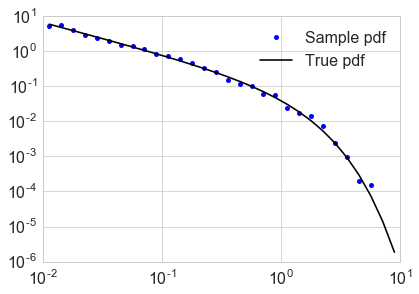

In [3]:
# set the length of the sample
n = 10000
# calculate the uniformly distributed y
r = np.random.rand(n)
# set the values of the shape and scale parameters
alpha = .1
beta = 1.
# calculate x values
sample = (1./beta)*ss.gammaincinv(alpha,r)
sample = stats.gamma.rvs(alpha, loc=0, scale=1./beta, size=n)

# plot sample against original distribution
cdf, x_axis = pdf_ccdf(sample, xmin=.01, xmax=10, numbin=30, return_flag=0, axis_flag=1)
plt.loglog(x_axis, cdf, 'b.', ms=10, label='Sample pdf')
cdf_2 = stats.gamma.pdf(x_axis, alpha, scale=1./beta)
plt.loglog(x_axis, cdf_2, 'k', label='True pdf')
plt.legend(loc=0)

### Estimating the parameters and finding the Fisher Information
We use the MLE algorithm in the scipy.stats module to obtain estimates of the gamma parameters for the given dataset, it is important to set floc=0, because this is not a relevant parameter for us. 

Once we have estimates of the parameters, we can use those to calculate the observed Fisher information, which is related to the second derivative of the log-likelihood function in the neighbourhood of the estimated parameters. However, it is more complicated than that in a bivariate estimation. In this case the Fisher Information is imbedded in the negative of the hessian of the second derivative over both parameters. The formula for this is:
\begin{equation}
    F_I = n\begin{bmatrix}
        \psi_1(\alpha) & -1/\beta \\
        -1/\beta & \alpha/\beta^2
     \end{bmatrix}
\end{equation}
where $\psi_1(\cdot)$ is the trigamma function. The variance of $\alpha$ and $\beta$ can be gotten from the inverse of this matrix. The Variance of $\alpha$ is the element 11, and that of $\beta$ is element 22. The covariance of $\alpha$ and $\beta$ is element 12 or 21.
\begin{equation}
    var(\alpha, \beta) = \frac{1}{n}\begin{bmatrix}
        \psi_1(\alpha) & -1/\beta \\
        -1/\beta & \alpha/\beta^2
     \end{bmatrix}^{-1}
\end{equation}

The expected Fisher Information would be that calculated as above with the true values of $alpha$ and $\beta$. The observed Fisher Information is that calculated with the estimated parameters. 

alpha = 0.1029 with a relative std dev of 3.310933 percent
beta = 1.0074 with a relative std dev of 10.399209 percent
Actual error: 
alpha = 2.900 percent 
beta = 0.736 percent


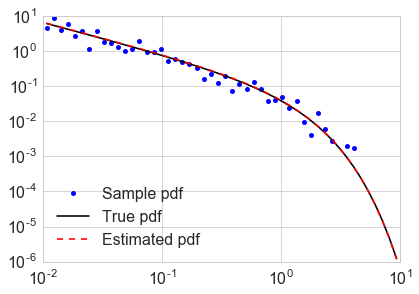

In [4]:
# use the scipy.stats module to estimate the parameter values of the 
# gamma dist from the given sample using the MLE method
(alpha_hat, loc_hat, pre_beta_hat) = stats.gamma.fit(sample, floc=0)
beta_hat = 1./pre_beta_hat
# calculate the observed Fisher information and from it the variance in the estimates
fisher_obv = [[ss.polygamma(1, alpha_hat), -1./beta_hat], [-1./beta_hat, alpha_hat/(beta_hat**2)]]
variance_obv = (1./n)*np.linalg.inv(fisher_obv)
alpha_var = variance_obv[0,0]
beta_var = variance_obv[1,1]

print 'alpha = %1.4f with a relative std dev of %1.6f percent' % (alpha_hat, 100.*(alpha_var**0.5)/alpha_hat)
print 'beta = %1.4f with a relative std dev of %1.6f percent' % (beta_hat, 100*(beta_var**0.5)/beta_hat)
print 'Actual error: \nalpha = %1.3f percent \nbeta = %1.3f percent' % (100*np.abs(alpha-alpha_hat)/alpha, 100*np.abs(beta-beta_hat)/beta)


# plot sample against original distribution
cdf, x_axis = pdf_ccdf(sample, xmin=.01, xmax=10, numbin=50, return_flag=0, axis_flag=1)
plt.loglog(x_axis, cdf, 'b.', ms=10, label='Sample pdf')
cdf_2 = stats.gamma.pdf(x_axis, alpha, scale=1./beta)
plt.loglog(x_axis, cdf_2, 'k', label='True pdf')
cdf_2 = stats.gamma.pdf(x_axis, alpha_hat, scale=1./beta_hat)
plt.loglog(x_axis, cdf_2, 'r--', label='Estimated pdf')
plt.legend(loc=0)

### Variance as a function of sample size
As the sample size increases the variance decreases. We can see that for samples drawn from the gamma distribution, the variance decreases very quickly. 

(0, 16)

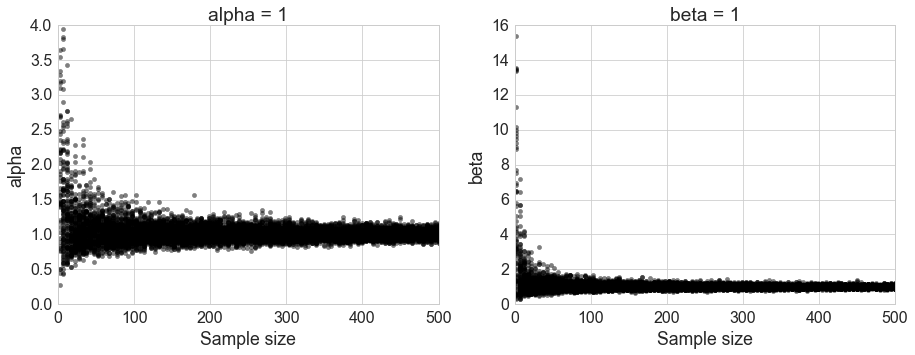

In [5]:
alpha = 1.
beta = 1.
ns = np.linspace(2,500,100)
nx = 100
alpha_hats = np.zeros((2,nx*ns.size))
beta_hats = np.zeros((2,nx*ns.size))
count = 0
for jj, n in enumerate(ns):
    for ii in range(nx):
        # generate sample
#         sample = (1./beta)*ss.gammaincinv(alpha,np.random.rand(int(n)))
        sample = stats.gamma.rvs(alpha, loc=0, scale=1./beta, size=n)
        
        # fit sample
        (alpha_hat, loc_hat, pre_beta_hat) = stats.gamma.fit(sample, floc=0)
        beta_hat = 1./pre_beta_hat
        alpha_hats[:,count] = [n, alpha_hat]
        beta_hats[:,count] = [n, beta_hat]
        count += 1

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.scatter(alpha_hats[0,:], alpha_hats[1,:], facecolor='k', edgecolor=None, alpha=0.5)
plt.ylabel('alpha')
plt.xlabel('Sample size')
plt.title('alpha = %g' % alpha)
plt.xlim([0,500])
plt.ylim([0,4])

plt.subplot(1, 2, 2)
plt.scatter(beta_hats[0,:], beta_hats[1,:], facecolor='k', edgecolor=None, alpha=0.5)
plt.xlabel('Sample size')
plt.ylabel('beta')
plt.title('beta = %g' % beta)
plt.xlim([0,500])
plt.ylim([0,16])

# plt.savefig('Variance_of_estimation.pdf', format='pdf', dpi=600)

### Fisher Information as a function of sample size
We can see as well that the Fisher information implies that the variance should decrease as a function of sample size. Also, the observed Fisher information is a good estimate of the expected (or true) Fisher information. 

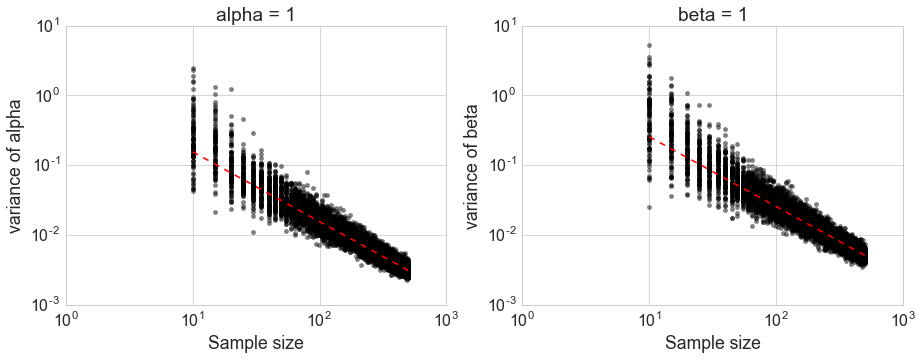

In [8]:
alpha = 1.
beta = 1.
ns = np.linspace(10,500,100)
nx = 100
alpha_hats = np.zeros((2,nx*ns.size))
beta_hats = np.zeros((2,nx*ns.size))
alpha_obv_fisher = np.zeros((2,nx*ns.size))
beta_obv_fisher = np.zeros((2,nx*ns.size))
count = 0
for jj, n in enumerate(ns):
    for ii in range(nx):
        # generate sample
#         sample = (1./beta)*ss.gammaincinv(alpha,np.random.rand(int(n)))
        sample = stats.gamma.rvs(alpha, loc=0, scale=1./beta, size=n)
        # fit sample
        (alpha_hat, loc_hat, pre_beta_hat) = stats.gamma.fit(sample, floc=0)
        beta_hat = 1./pre_beta_hat
        alpha_hats[:,count] = [n, alpha_hat]
        beta_hats[:,count] = [n, beta_hat]

        obv_fisher = np.asarray([[ss.polygamma(1, alpha_hat), -1./beta_hat], [-1./beta_hat, alpha_hat/(beta_hat**2)]])
        obv_fisher_inv = (1./n)*np.linalg.inv(obv_fisher)
        alpha_obv_fisher[:,count] = [n, obv_fisher_inv[0,0]]
        beta_obv_fisher[:,count] = [n, obv_fisher_inv[1,1]]
        count += 1

        
unit_exp_fisher = [[ss.polygamma(1, alpha), -1./beta], [-1./beta, alpha/(beta**2)]]
alpha_exp_fisher = np.zeros(ns.size)
beta_exp_fisher = np.zeros(ns.size)
for ij, n in enumerate(ns):
    exp_fisher_inv = (1./n)*np.linalg.inv(unit_exp_fisher)
    alpha_exp_fisher[ij] = exp_fisher_inv[0,0]
    beta_exp_fisher[ij] = exp_fisher_inv[1,1]
    
fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.loglog(ns, alpha_exp_fisher, 'r--')
plt.scatter(alpha_obv_fisher[0,:], alpha_obv_fisher[1,:], facecolor='k', edgecolor=None, alpha=0.5)
plt.ylabel('variance of alpha')
plt.xlabel('Sample size')
plt.title('alpha = %g' % alpha)
# plt.xlim([10,1000])
# plt.ylim([1e-5,3])

plt.subplot(1, 2, 2)
plt.loglog(ns, beta_exp_fisher, 'r--')
plt.scatter(beta_obv_fisher[0,:], beta_obv_fisher[1,:], facecolor='k', edgecolor=None, alpha=0.5)
plt.xlabel('Sample size')
plt.ylabel('variance of beta')
plt.title('beta = %g' % beta)
# plt.xlim([10,1000])
# plt.ylim([1e-5,3])

# plt.savefig('Fisher_information.pdf', format='pdf', dpi=600)

### Observed Fisher information to estimate variance of estimated parameters
We can see that we can use the observed fisher information to accurately estimate the amount of variance (and therefore error) that we can expect in our estimated parameters

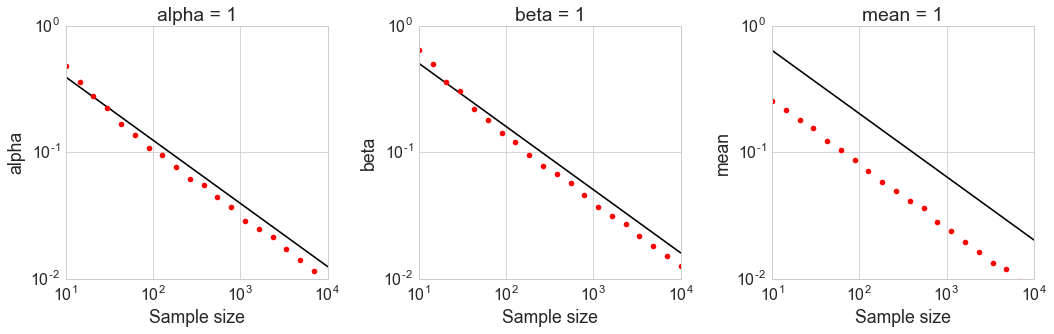

In [9]:
alpha = 1.
beta = 1.
mean = alpha/beta
ns = np.logspace(1,4,20)
nx = 1000
alpha_hats = np.zeros((2,nx*ns.size))
beta_hats = np.zeros((2,nx*ns.size))
mean_hats = np.zeros((2,nx*ns.size))
count = 0
for jj, n in enumerate(ns):
    for ii in range(nx):
        # generate sample
#         sample = (1./beta)*ss.gammaincinv(alpha,np.random.rand(int(n)))
        sample = stats.gamma.rvs(alpha, loc=0, scale=1./beta, size=n)
        # fit sample
        (alpha_hat, loc_hat, pre_beta_hat) = stats.gamma.fit(sample, floc=0)
        beta_hats[:,count] = [n, 1./pre_beta_hat]
        alpha_hats[:,count] = [n, alpha_hat]
        mean_hats[:,count] = [n, alpha_hat*pre_beta_hat]
        count += 1
        
unit_exp_fisher = np.asarray([[ss.polygamma(1, alpha), -1./beta], [-1./beta, alpha/(beta**2)]])
alpha_exp_fisher = np.zeros(ns.size)
beta_exp_fisher = np.zeros(ns.size)
alpha_exp_std = np.zeros(ns.size)
alpha_obv_std = np.zeros(ns.size)
beta_exp_std = np.zeros(ns.size)
beta_obv_std = np.zeros(ns.size)
mean_exp_std = np.zeros(ns.size)
mean_obv_std = np.zeros(ns.size)

for ij, n in enumerate(ns):
    exp_fisher_inv = (1./n)*np.linalg.inv(unit_exp_fisher)
    alpha_exp_fisher[ij] = exp_fisher_inv[0,0]
    alpha_exp_std[ij] = np.sqrt(exp_fisher_inv[0,0])
    alpha_obv_std[ij] = np.mean(np.sqrt((alpha_hats[1, alpha_hats[0,:] == n] - alpha)**2))
    beta_exp_fisher[ij] = exp_fisher_inv[1,1]
    beta_exp_std[ij] = np.sqrt(exp_fisher_inv[1,1])
    beta_obv_std[ij] = np.mean(np.sqrt((beta_hats[1, beta_hats[0,:] == n] - beta)**2))
#     mean_exp_std[ij] = np.sqrt((1./beta**2) * (exp_fisher_inv[0,0] - 2.*np.sqrt(exp_fisher_inv[0,1])*alpha/beta + exp_fisher_inv[1,1]*(alpha**2/beta**2)))
    mean_exp_std[ij] = np.sqrt((1./beta**2) * (exp_fisher_inv[0,0] + exp_fisher_inv[1,1]*(alpha**2/beta**2)))
    mean_obv_std[ij] = np.mean(np.sqrt((mean_hats[1, mean_hats[0,:] == n] - mean)**2))
    
fig = plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.loglog(ns, alpha_exp_std/alpha, 'k')
plt.plot(ns, alpha_obv_std/alpha, 'ro')
plt.ylabel('alpha')
plt.xlabel('Sample size')
plt.title('alpha = %g' % alpha)
plt.xlim([10,10000])
plt.ylim([1e-2,1])

plt.subplot(1, 3, 2)
plt.loglog(ns, beta_exp_std/beta, 'k')
plt.plot(ns, beta_obv_std/beta, 'ro')
plt.xlabel('Sample size')
plt.ylabel('beta')
plt.title('beta = %g' % beta)
plt.xlim([10,10000])
plt.ylim([1e-2,1])

plt.subplot(1, 3, 3)
plt.loglog(ns, mean_exp_std/mean, 'k')
plt.loglog(ns, mean_obv_std/mean, 'ro')
plt.xlabel('Sample size')
plt.ylabel('mean')
plt.title('mean = %g' % mean)
plt.xlim([10,10000])
plt.ylim([1e-2,1])

plt.tight_layout()
# plt.savefig('Variance_of_estimation.pdf', format='pdf', dpi=600)

### $r^2$ value as a goodness of fit indicator
We use the $r^2$ value of the theoretical quantiles to the observed quantiles as an indicator of the goodness of fit.

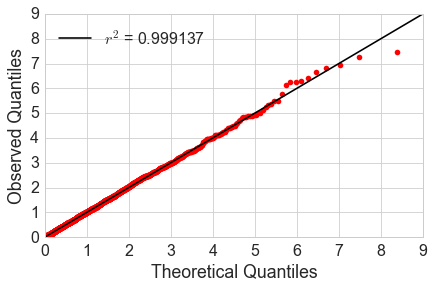

In [6]:
alpha = 1.
beta = 1.
mean = alpha/beta
# ns = np.linspace(10,10000,30)
ns = np.array([3000])
nx = 1
# r_2 = np.zeros((2,nx*ns.size))
count = 0
for jj, n in enumerate(ns):
    for ii in range(nx):
        # generate sample
        x = stats.gamma.rvs(alpha*1., loc=0, scale=1./beta, size=n) 
        res = stats.probplot(x, dist=stats.gamma, sparams=(alpha, 0, 1./beta), fit=False, plot=None)
        r2 = (1. - np.sum((res[1] - res[0])**2) / np.sum(res[1]**2))**2

plt.plot(res[0], res[1], 'ro')
max_x = max([max(res[0]), max(res[1])])
x = np.linspace(0, max_x+2, 10)
plt.plot(x, x, 'k', label='$r^2$ = %g' % r2)
plt.legend(loc=0)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Observed Quantiles')
plt.xlim([0, np.round(max_x+1)])
plt.ylim([0, np.round(max_x+1)])
plt.tight_layout()